In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import skimage.io
import glob
import tqdm
import os

from glob import glob
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

%matplotlib inline

In [2]:
IMG_PATH = 'C:\\Users\\Bipasha\\brain_tumor_dataset/'

In [3]:
#IMG_PATH =os.listdir('C:\\Users\\Bipasha\\brain_tumor_dataset/')

In [4]:
cancerous      = os.listdir('C:\\Users\\Bipasha\\brain_tumor_dataset//yes')
non_cancerous  = os.listdir('C:\\Users\\Bipasha\\brain_tumor_dataset//no') 

In [5]:
len(cancerous),len(non_cancerous)


(155, 98)

Viewing Dataset - Cancerous 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 60.28it/s]


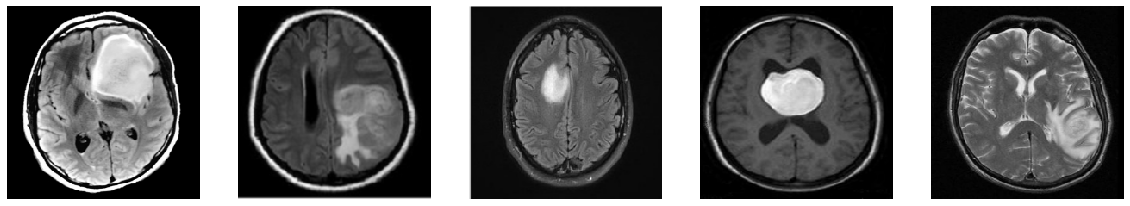

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(cancerous))
    img  = imread('C:\\Users\\Bipasha\\brain_tumor_dataset//yes/' + cancerous[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 54.48it/s]


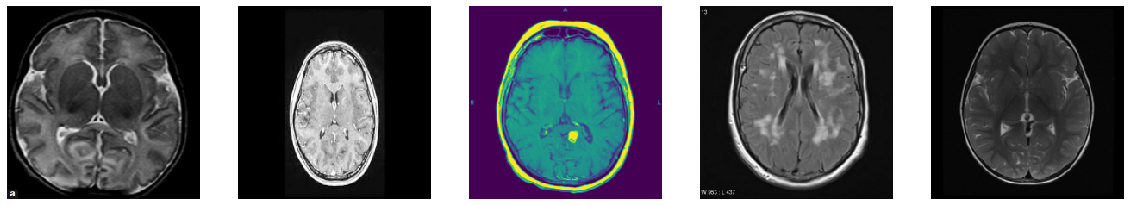

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(non_cancerous))
    img  = imread('C:\\Users\\Bipasha\\brain_tumor_dataset//no/' + non_cancerous[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

# Converting images into proper shape and storing tehm as asn array.

In [8]:

Image = []
Label = []

for i in tqdm(range(0, len(cancerous))):
    img = imread('C:\\Users\\Bipasha\\brain_tumor_dataset//yes/' + cancerous[i])
    img = resize(img, (224, 224, 3))
    Image.append(img)
    Label.append(1)
    
for i in tqdm(range(0, len(non_cancerous))):
    img = imread('C:\\Users\\Bipasha\\brain_tumor_dataset//no/' + non_cancerous[i])
    img = resize(img, (224, 224, 3))
    Image.append(img)
    Label.append(0)
    
Image = np.array(Image)
Label = np.array(Label) 

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:02<00:00, 48.48it/s]


# Shuffle the data as results are appened.

In [9]:

Image, Label = shuffle(Image, Label, random_state = 42)

# Viewing Image - After Shuffle 


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 626.33it/s]


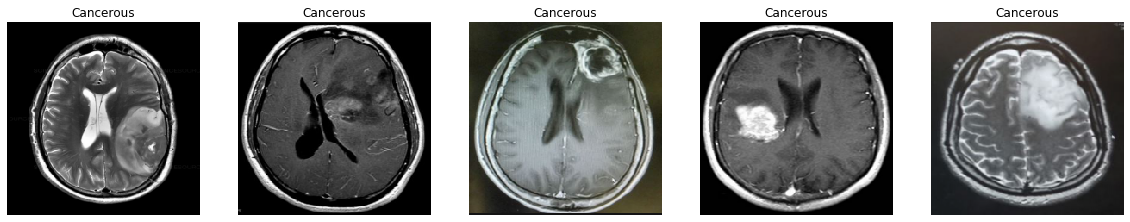

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(Image))
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    a = Label[rand]
    if a == 1:
        ax[i].set_title('Cancerous')
    else:
        ax[i].set_title('Non_Cancerous')

In [11]:
X = Image 
y = Label

# Preprocess Data
X = preprocess_input(X)

# Converting target label to categorical since we are including 2 neuron at output layer. 
y = to_categorical(y)

DATA AUGMENTATION

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [13]:
train_datagen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')

train_datagen.fit(X_train)

MODEL BUILDING

In [14]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [15]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

 We dont want to train all layers so, we do following step because we are using same weights given in VGG16

In [16]:
for layers in vgg16.layers:
    layers.trainable = False

In [17]:
x = Flatten()(vgg16.output)

In [18]:

fcc_layer   = Dense(units = 1024, activation = 'relu')(x)
final_layer = Dense(units = 2, activation = 'softmax')(fcc_layer)

In [19]:
model = Model(inputs = vgg16.input, outputs = final_layer)

In [20]:

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
model.compile(optimizer = tensorflow.keras.optimizers.Adam(1e-6), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [22]:
filepath = './best_weights.h5'

earlystopping   = EarlyStopping(monitor = 'val_accuracy', 
                                mode='max', 
                                patience = 10, 
                                verbose = 1)

modelcheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_accuracy', 
                                  mode = 'max', 
                                  verbose = 1, 
                                  save_best_only=True)

callback_list = [earlystopping, modelcheckpoint]

In [23]:
model_history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),  
                          validation_data = (X_test, y_test),
                          epochs = 20,
                          verbose = 1,
                          callbacks = callback_list)

  ...
    to  
  ['...']
Train for 6 steps, validate on 76 samples
Epoch 1/20
5/6 [========================>.....] - ETA: 27s - loss: 2.7381 - accuracy: 0.343 - ETA: 20s - loss: 2.5982 - accuracy: 0.375 - ETA: 12s - loss: 2.2799 - accuracy: 0.419 - ETA: 9s - loss: 2.4201 - accuracy: 0.380 - ETA: 4s - loss: 2.3474 - accuracy: 0.4000
Epoch 00001: val_accuracy improved from -inf to 0.38158, saving model to ./best_weights.h5
6/6 [==============================] - 47s 8s/step - loss: 2.3809 - accuracy: 0.3898 - val_loss: 2.2738 - val_accuracy: 0.3816
Epoch 2/20
5/6 [========================>.....] - ETA: 36s - loss: 2.4499 - accuracy: 0.343 - ETA: 26s - loss: 2.4120 - accuracy: 0.343 - ETA: 19s - loss: 2.3013 - accuracy: 0.364 - ETA: 11s - loss: 2.0858 - accuracy: 0.398 - ETA: 5s - loss: 2.1579 - accuracy: 0.3724 
Epoch 00002: val_accuracy did not improve from 0.38158
6/6 [==============================] - 48s 8s/step - loss: 2.0933 - accuracy: 0.3898 - val_loss: 1.9863 - val_accuracy: 0.38

5/6 [========================>.....] - ETA: 18s - loss: 0.7571 - accuracy: 0.411 - ETA: 19s - loss: 0.7223 - accuracy: 0.510 - ETA: 16s - loss: 0.7037 - accuracy: 0.543 - ETA: 11s - loss: 0.6891 - accuracy: 0.575 - ETA: 5s - loss: 0.6759 - accuracy: 0.5931 
Epoch 00018: val_accuracy did not improve from 0.61842
6/6 [==============================] - 49s 8s/step - loss: 0.6653 - accuracy: 0.6215 - val_loss: 0.6420 - val_accuracy: 0.6053
Epoch 19/20
5/6 [========================>.....] - ETA: 18s - loss: 0.7463 - accuracy: 0.411 - ETA: 20s - loss: 0.6743 - accuracy: 0.612 - ETA: 16s - loss: 0.6657 - accuracy: 0.629 - ETA: 11s - loss: 0.6696 - accuracy: 0.601 - ETA: 5s - loss: 0.6728 - accuracy: 0.6000 
Epoch 00019: val_accuracy did not improve from 0.61842
6/6 [==============================] - 51s 8s/step - loss: 0.6680 - accuracy: 0.6102 - val_loss: 0.6421 - val_accuracy: 0.6053
Epoch 20/20
5/6 [========================>.....] - ETA: 34s - loss: 0.6265 - accuracy: 0.656 - ETA: 21s - lo